In [6]:
import warnings
warnings.filterwarnings('ignore') 

from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

# import lime
# import lime.lime_tabular
from glime import lime_tabular
import shap
from copy import deepcopy

### Setup
Let's begin by examining the COMPAS data set.  This data set consists of defendent information from 
Broward Couty, Florida. Let's suppose that some adversary wants to _mask_ baised or racist behavior on this data set.

In [7]:
# Get the data set and do some preprocessing
params = Params("model_configurations/experiment_params.json")
np.random.seed(params.seed)
X, y, cols = get_and_preprocess_compas_data(params)

# Add a random column -- this is what we'll have LIME/SHAP explain.
X['unrelated_column'] = np.random.choice([0,1],size=X.shape[0])
features = [c for c in X]

categorical_feature_name = ['two_year_recid', 'c_charge_degree_F', 'c_charge_degree_M',\
                            'sex_Female', 'sex_Male', 'race', 'unrelated_column']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]

race_indc = features.index('race')
unrelated_indcs = features.index('unrelated_column')
X = X.values

Next, let's set up our model f and psi.  f is the what we _actually_ want to classify the data by and psi
is what we want LIME/SHAP to explain.

In [8]:
class racist_model_f:
    # Decision rule: classify negatively if race is black
    def predict(self,X):
        return np.array([params.negative_outcome if x[race_indc] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)
    
class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([params.negative_outcome if x[unrelated_indcs] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [9]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

# Train the adversarial model for LIME with f and psi 
adv_lime = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features, categorical_features=categorical_feature_indcs)

Great, that's it! Now let's look at LIME explanations.

We'll go through SHAP after.

In [81]:
# # Let's just look at a the first example in the test set
# ex_indc = np.random.choice(xtest.shape[0])

# # To get a baseline, we'll look at LIME applied to the biased model f
# normal_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(),
#                                                           discretize_continuous=False,
#                                                           categorical_features=categorical_feature_indcs)

# normal_exp = normal_explainer.explain_instance(xtest[ex_indc], racist_model_f().predict_proba).as_list()

# print ("Explanation on biased f:\n",normal_exp[:3],"\n\n")

# # Now, lets look at the explanations on the adversarial model 
# adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(), 
#                                                        discretize_continuous=False,
#                                                        categorical_features=categorical_feature_indcs)

# adv_exp = adv_explainer.explain_instance(xtest[ex_indc], adv_lime.predict_proba).as_list()

# print ("Explanation on adversarial model:\n",adv_exp[:3],"\n")

# print("Prediction fidelity: {0:3.2}".format(adv_lime.fidelity(xtest[ex_indc:ex_indc+1])))

Explanation on biased f:
 [('race=0', -0.9940824993461665), ('unrelated_column=-1', -0.0003168346987562742), ('sex_Male=0', -0.00029448914215418756)] 


Explanation on adversarial model:
 [('race=0', -0.9941627522102745), ('length_of_stay', -0.0007807859294790298), ('two_year_recid=0', -0.00023758630611220362)] 

Prediction fidelity: 1.0


In [82]:
# Let's just look at a the first example in the test set
ex_indc = np.random.choice(xtest.shape[0])

# To get a baseline, we'll look at LIME applied to the biased model f
normal_explainer = lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(),
                                                          discretize_continuous=False,
                                                          categorical_features=categorical_feature_indcs,
                                                          sample_around_instance=False) # sample_around_instance=False

normal_exp = normal_explainer.explain_instance(xtest[ex_indc], racist_model_f().predict_proba, num_samples=1000, sampling_method="empirical").as_list()
# num_samples=1000, sampling_method="empirical"

print ("Explanation on biased f:\n",normal_exp[:3],"\n\n")

# Now, lets look at the explanations on the adversarial model 
adv_explainer = lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(), 
                                                       discretize_continuous=False,
                                                       categorical_features=categorical_feature_indcs,
                                                       sample_around_instance=False) # sample_around_instance=False

adv_exp = adv_explainer.explain_instance(xtest[ex_indc], adv_lime.predict_proba, num_samples=1000, sampling_method="empirical").as_list()
# num_samples=1000, sampling_method="empirical"

print ("Explanation on adversarial model:\n",adv_exp[:3],"\n")

print("Prediction fidelity: {0:3.2}".format(adv_lime.fidelity(xtest[ex_indc:ex_indc+1])))

Explanation on biased f:
 [('race=0', -0.9936568750781758), ('sex_Female=2', -0.0007447537146058607), ('priors_count', 0.00043325677631358896)] 


Explanation on adversarial model:
 [('race=0', -0.9937646812435956), ('sex_Female=2', 0.0002780490198107897), ('length_of_stay', 0.0002728426034806885)] 

Prediction fidelity: 1.0


### LIME Results
What we have is the top three features of the explanation on the biased model followed by the explanation on that same instance using the adversarial model. We see that the top feature is now the randomly drawn column, indicating that the attack was able to fool LIME. We also see that the adversarial model predicts this instance _the same_ as the biased model (fidelity=1)—although the model predicts the same results, its reasoning has changed.

Next, let's look at the SHAP adversarial model.  We'll go through a similar process as above except using SHAP.

In [12]:
# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features)

100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


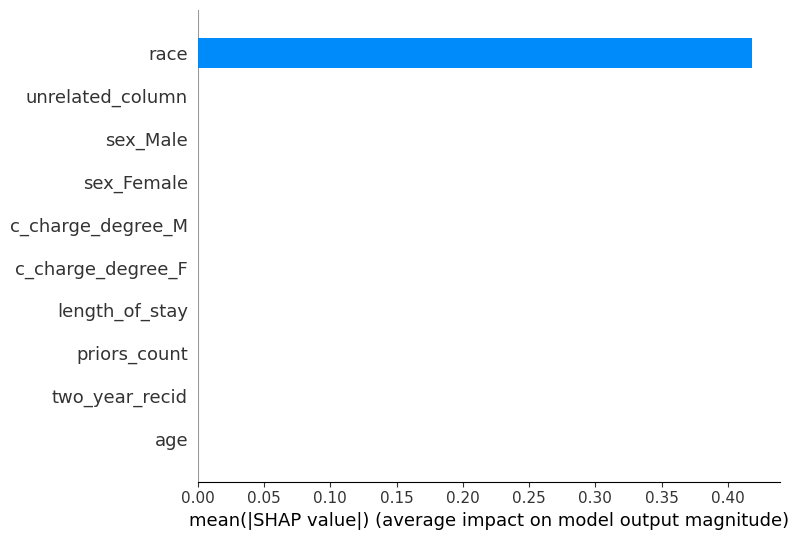

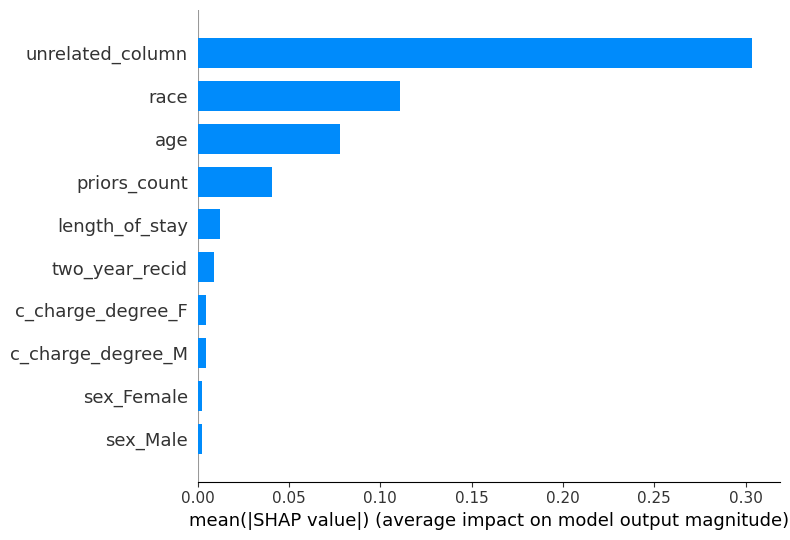

Fidelity: 1.0


In [13]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot it using SHAP's plotting features.
shap.summary_plot(biased_shap_values, feature_names=features, plot_type="bar")
shap.summary_plot(adv_shap_values, feature_names=features, plot_type="bar")

print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))

### SHAP Results
The first plot is SHAP applied to the biased model.  The second plot is SHAP applied to the adversarial model.  These plots give a summary of the SHAP values for each feature.  We see the randomly drawn column looks like it has
much more impact on the model than race does now, though race still looks important.  We also see that adversarial model predicts this instance the same as the biased model.

### Commentary
What do these results mean? It's _possible_ for an adversary to exploit perturabtion based post hoc explanation techniques like LIME and SHAP.  In safety concerned situations, it is prudent _not_ to trust post hoc explanations given by LIME and SHAP because adversaries can potentially exploit their explanations.

## Showing OOD with PCA on COMPAS

### LIME perturbed

6172


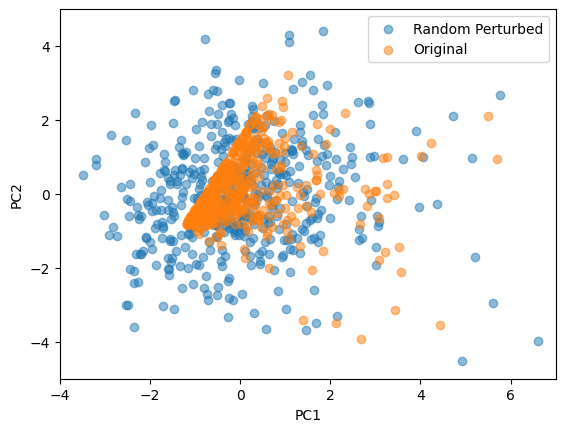

In [168]:
from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap

from copy import deepcopy


params = Params("model_configurations/experiment_params.json")
X, y, cols = get_and_preprocess_compas_data(params)
features = [c for c in X]

race_indc = features.index('race')

X = X.values
c_cols = [features.index('c_charge_degree_F'), features.index('c_charge_degree_M'), features.index('two_year_recid'), features.index('race'), features.index("sex_Male"), features.index("sex_Female")]

X = np.delete(X, c_cols, axis=1)

ss = StandardScaler().fit(X)
X = ss.transform(X)


r = []
for _ in range(1):
	p = np.random.normal(0,1,size=X.shape)
	
	# for row in p:
	# 	for c in c_cols:
	# 		row[c] = np.random.choice(X[:,c])

	X_p = X + p
	r.append(X_p)

r = np.vstack(r)
p = [1 for _ in range(len(r))]
iid = [0 for _ in range(len(X))]

all_x = np.vstack((r,X))
all_y = np.array(p + iid)

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
results = pca.fit_transform(all_x)

print (len(X))

plt.scatter(results[:500, 0], results[:500, 1], alpha=0.5, label='Random Perturbed', color = '#1f77b4')
plt.scatter(results[6173:6672, 0], results[6173:6672, 1], alpha=0.5, label='Original', color = '#ff7f0e')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-4, 7)
plt.ylim(-5, 5)
plt.legend()
plt.savefig('images/pca_random_perturbed.png', dpi=300)
plt.show()

### KNN Perturbed

6172


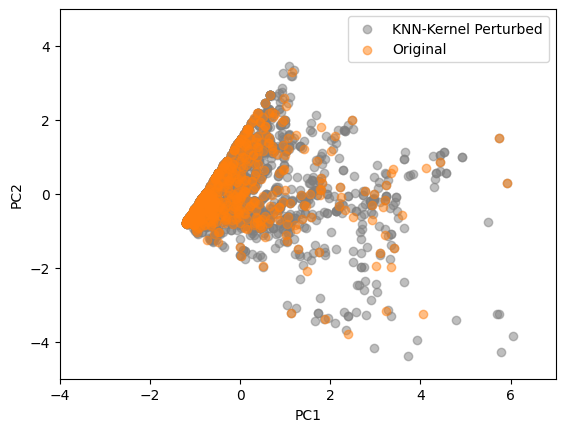

In [169]:
from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap

from copy import deepcopy


params = Params("model_configurations/experiment_params.json")
X, y, cols = get_and_preprocess_compas_data(params)
features = [c for c in X]

race_indc = features.index('race')

X = X.values
c_cols = [features.index('c_charge_degree_F'), features.index('c_charge_degree_M'), features.index('two_year_recid'), features.index('race'), features.index("sex_Male"), features.index("sex_Female")]

X = np.delete(X, c_cols, axis=1)

ss = StandardScaler().fit(X)
X = ss.transform(X)

r = []
# for _ in range(1):
# 	p = np.random.normal(0,0.1,size=X.shape)
# 	X_p = X + p
# 	r.append(X_p)
	
from sklearn.neighbors import KDTree
kdt = KDTree(X, leaf_size=30, metric='euclidean')
for i in range(X.shape[0]):
	distances, indices = kdt.query(X[i].reshape(1, -1), k=6)
	X_p = X[indices[0][1:]]
	r.append(X_p)
	# print(X_p)

r = np.vstack(r)
p = [1 for _ in range(len(r))]
iid = [0 for _ in range(len(X))]

all_x = np.vstack((r,X))
all_y = np.array(p + iid)

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
results = pca.fit_transform(all_x)

print (len(X))

plt.scatter(results[:2500, 0], results[:2500, 1], alpha=0.5, label='KNN-Kernel Perturbed', color='#7f7f7f')
plt.scatter(results[30861:31361, 0], results[30861:31361, 1], alpha=0.5, label='Original', color = '#ff7f0e')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.xlim(-4, 7)
plt.ylim(-5, 5)
plt.savefig('images/pca_knnkd_perturbed.png', dpi=300)
plt.show()

## Perturbation Detection Accuracy

<Axes: xlabel='F1 score on OOD task', ylabel='% explanations with race as first feature'>

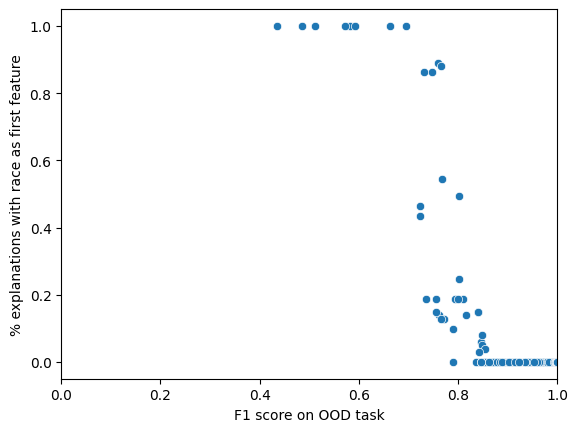

In [163]:
"""
* Methods to create graphs for f1 accuracy on perturbation task graphs.
"""
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('data/threshold_results_lime.csv', index_col=0)
f1s, fsts, scnds, thrds = [], [], [], []

for trial in np.unique(df['trial']):
	relevant_runs = df[df.trial == trial]

	yhat = relevant_runs['yhat']
	y = relevant_runs['y']

	# need to flip classes (we interpret 0 as ood in code but refer to it as 1 in paper)
	yhat = 1 - yhat
	y = 1 - y

	pct_first = relevant_runs['pct_occur_first'].values[0]
	pct_second = relevant_runs['pct_occur_second'].values[0]
	pct_third = relevant_runs['pct_occur_third'].values[0]

	f1 = f1_score(y, yhat)

	f1s.append(f1)
	fsts.append(pct_first)
	scnds.append(pct_second)
	thrds.append(pct_third)

ax = plt.axes()
plt.ylim(-.05,1.05)
plt.xlim(0,1)

plt.xlabel("F1 score on OOD task")
plt.ylabel("% explanations with race as first feature")

sns.scatterplot(x=f1s, y=fsts, ax=ax)

<Axes: xlabel='F1 score on OOD task', ylabel='% explanations with race as first feature'>

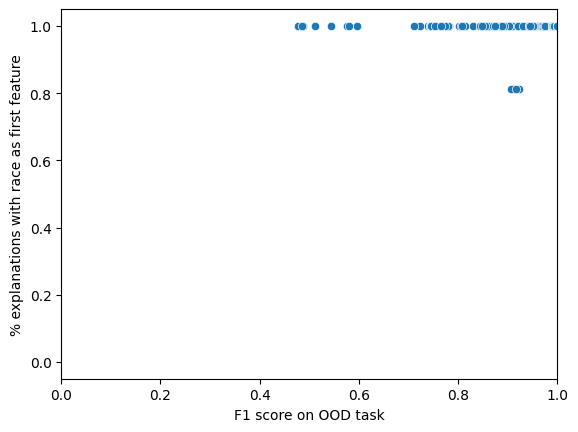

In [88]:
"""
* Methods to create graphs for f1 accuracy on perturbation task graphs.
"""
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('data/threshold_results_glime.csv', index_col=0)
f1s, fsts, scnds, thrds = [], [], [], []

for trial in np.unique(df['trial']):
	relevant_runs = df[df.trial == trial]

	yhat = relevant_runs['yhat']
	y = relevant_runs['y']

	# need to flip classes (we interpret 0 as ood in code but refer to it as 1 in paper)
	yhat = 1 - yhat
	y = 1 - y

	pct_first = relevant_runs['pct_occur_first'].values[0]
	pct_second = relevant_runs['pct_occur_second'].values[0]
	pct_third = relevant_runs['pct_occur_third'].values[0]

	f1 = f1_score(y, yhat)

	f1s.append(f1)
	fsts.append(pct_first)
	scnds.append(pct_second)
	thrds.append(pct_third)

ax = plt.axes()
plt.ylim(-.05,1.05)
plt.xlim(0,1)

plt.xlabel("F1 score on OOD task")
plt.ylabel("% explanations with race as first feature")

sns.scatterplot(x=f1s, y=fsts, ax=ax)


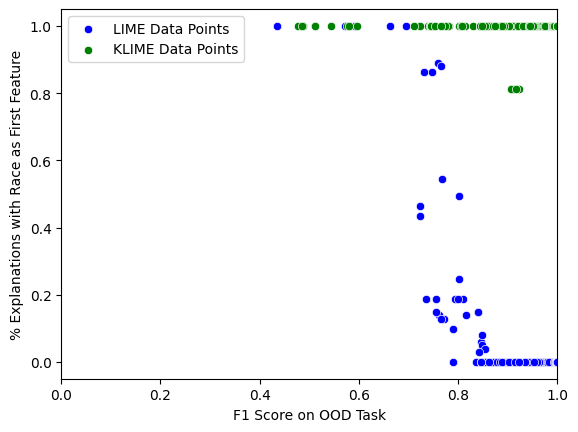

In [193]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline

# Load first dataset
df_lime = pd.read_csv('data/threshold_results_lime.csv', index_col=0)
f1s_lime, fsts_lime = [], []

for trial in np.unique(df_lime['trial']):
    relevant_runs = df_lime[df_lime.trial == trial]
    yhat = 1 - relevant_runs['yhat']
    y = 1 - relevant_runs['y']
    pct_first = relevant_runs['pct_occur_first'].values[0]

    f1 = f1_score(y, yhat)
    f1s_lime.append(f1)
    fsts_lime.append(pct_first)

# Load second dataset
df_glime = pd.read_csv('data/threshold_results_glime.csv', index_col=0)
f1s_glime, fsts_glime = [], []

for trial in np.unique(df_glime['trial']):
    relevant_runs = df_glime[df_glime.trial == trial]
    yhat = 1 - relevant_runs['yhat']
    y = 1 - relevant_runs['y']
    pct_first = relevant_runs['pct_occur_first'].values[0]

    f1 = f1_score(y, yhat)
    f1s_glime.append(f1)
    fsts_glime.append(pct_first)

# Create figure and axis
fig, ax = plt.subplots()
plt.ylim(-0.05, 1.05)
plt.xlim(0, 1)
plt.xlabel("F1 Score on OOD Task")
plt.ylabel("% Explanations with Race as First Feature")

# Scatter plot for LIME data
sns.scatterplot(x=f1s_lime, y=fsts_lime, ax=ax, color='blue', label='LIME Data Points')

# Scatter plot for GLIME data
sns.scatterplot(x=f1s_glime, y=fsts_glime, ax=ax, color='green', label='KLIME Data Points')

plt.legend()
plt.savefig('images/f1_OOD_task.png', dpi=300)
plt.show()